In [1]:
import pandas as pd
import numpy as np

In [2]:
total_data = pd.read_csv('raw-data-binance/BTCUSDT-tradelist-from-1648395881176.csv')

In [3]:
total_data

,id,price,qty,quoteQty,time,isBuyerMaker
0,1305826000,44807.15,0.00299,133.973378,1648395881176,True
1,1305826001,44807.16,0.00680,304.688688,1648395881393,False
2,1305826002,44807.15,0.00445,199.391818,1648395881532,True
3,1305826003,44807.15,0.01227,549.783731,1648395881699,True
4,1305826004,44807.15,0.01000,448.071500,1648395881709,True
...,...,...,...,...,...,...
14999995,1320825995,42483.27,0.00049,20.816802,1649479680039,True
14999996,1320825996,42483.27,0.00074,31.437620,1649479680040,True
14999997,1320825997,42483.27,0.00090,38.234943,1649479680040,True
14999998,1320825998,42483.27,0.00082,34.836281,1649479680041,True


In [4]:
arr = np.array(total_data)

In [5]:
arr

array([[1305826000, 44807.15, 0.00299, 133.9733785, 1648395881176, True],
       [1305826001, 44807.16, 0.0068, 304.688688, 1648395881393, False],
       [1305826002, 44807.15, 0.00445, 199.3918175, 1648395881532, True],
       ...,
       [1320825997, 42483.27, 0.0009, 38.234943, 1649479680040, True],
       [1320825998, 42483.27, 0.00082, 34.8362814, 1649479680041, True],
       [1320825999, 42483.28, 0.00152, 64.5745856, 1649479680042, False]],
      dtype=object)

# Who is taker?

In [6]:
rep1 = np.append((arr[:-1,4] == arr[1:,4]),False)
rep2 = np.insert(arr[:-1,4] == arr[1:,4], 0, False)
rep = np.array([rep1, rep2]).T.any(axis=1)

non_rep = np.invert(rep)

takers = arr[non_rep]

rep = arr[rep]

t = rep[np.invert(np.append(rep[:-1,4] == rep[1:,4], False))]

t_list = np.split(rep, np.unique(rep[:,4], return_index=True)[1][1:])

c = 0
for taker in t_list:
    t[c] = taker[:,0].max(), taker[:,1].take(0), taker[:,2].sum(), taker[:,3].sum(), taker[:,4].max(), taker[:,5].any()
    c += 1
    
takers = np.concatenate((takers, t))
takers = takers[takers[:,0].argsort()]
takers[:,5] = np.piecewise(takers[:,5], [takers[:,5]==True,takers[:,5]==False], [False,True])

In [ ]:
takers_df = pd.DataFrame(takers, columns=['id','price','qty','quoteQty','time','isBuyer'])

# Who is maker?

In [ ]:
rep1 = np.append((arr[:-1,1] == arr[1:,1]),False)
rep2 = np.insert(arr[:-1,1] == arr[1:,1], 0, False)
rep = np.array([rep1, rep2]).T.any(axis=1)

non_rep = np.invert(rep)

makers = arr[non_rep]

rep = arr[rep]

non_m1 = np.append((rep[:-1,0]+1 == rep[1:,0]) & (rep[:-1,1] == rep[1:,1]) & (rep[:-1,4] != rep[1:,4]),False)
non_m2 = np.insert((rep[:-1,0]+1 == rep[1:,0]) & (rep[:-1,1] == rep[1:,1]) & (rep[:-1,4] != rep[1:,4]), 0, False)
non_m = np.array([non_m1, non_m2]).T.any(axis=1)
m = np.invert(non_m)
makers = np.concatenate((makers, rep[m]))
rep = rep[non_m]

m = rep[np.invert(np.append((rep[:-1,0]+1 == rep[1:,0]) & (rep[:-1,1] == rep[1:,1]) & (rep[:-1,4] != rep[1:,4]), False))]

m_list = np.split(rep, np.arange(1, rep.shape[0]+1)[np.invert(np.append((rep[:-1,0]+1 == rep[1:,0]) & (rep[:-1,1] == rep[1:,1]) & (rep[:-1,4] != rep[1:,4]), False))])
del m_list[-1]

c = 0
for maker in m_list:
    m[c] = maker[:,0].max(), maker[:,1].take(0), maker[:,2].sum(), maker[:,3].sum(), maker[:,4].max(), maker[:,5].any()
    c += 1
    
makers = np.concatenate((makers, m))
makers = makers[makers[:,0].argsort()]

In [13]:
makers_df = pd.DataFrame(makers, columns=['id','price','qty','quoteQty','time','isBuyer'])

# To K-lines

In [14]:
import time
import datetime
import enum

In [15]:
class TimeType:
    def __init__(self, val: str, uSize: int):
        self.val = val
        self.uSize = uSize


class TimeFrame(enum.Enum):
    sec1 = TimeType('1sec', 1 * 1000)
    sec10 = TimeType('10sec', 10 * 1000)
    min1 = TimeType('1m', 1 * 60 * 1000)
    min3 = TimeType('3m', 3 * 60 * 1000)
    min5 = TimeType('5m', 5 * 60 * 1000)
    min15 = TimeType('15m', 15 * 60 * 1000)
    min30 = TimeType('30m', 30 * 60 * 1000)

    hour1 = TimeType('1h', 1 * 3600 * 1000)
    hour2 = TimeType('2h', 2 * 3600 * 1000)
    hour4 = TimeType('4h', 4 * 3600 * 1000)
    hour6 = TimeType('6h', 6 * 3600 * 1000)
    hour8 = TimeType('8h', 8 * 3600 * 1000)
    hour12 = TimeType('12h', 12 * 3600 * 1000)

    day1 = TimeType('1d', 24 * 3600 * 1000)

    week1 = TimeType('1w', 7 * 24 * 3600 * 1000)


In [16]:
def to_Kline(arr: np.array, interval: TimeFrame, fr: str, to: str):
    fr_stamp = int(time.mktime(datetime.datetime.strptime(fr, '%Y-%m-%d').timetuple()) * 1000)
    to_stamp = int(time.mktime(datetime.datetime.strptime(to, '%Y-%m-%d').timetuple()) * 1000)
    t_slice = []
    for t in range(fr_stamp, to_stamp, interval.value.uSize):
        t_slice.append(t)

    sliced_arr = arr[(arr[:,4] >= fr_stamp-interval.value.uSize) & (arr[:,4] <= to_stamp-interval.value.uSize)]
    where = np.searchsorted(sliced_arr[:,4], t_slice)
    splitted_ticks = np.split(sliced_arr, where)
    del splitted_ticks[-1]

    kline = np.array([])
    prev_candle = np.array([t_slice[0]-interval.value.uSize, 0 , 0 , 0, 0, 0, 0, 0])
    c = 0
    for s_tick in splitted_ticks:
        if s_tick.shape[0] != 0:
            candle = np.array([t_slice[c], s_tick[:,1].take(0), s_tick[:,1].max(), s_tick[:,1].min(), s_tick[:,1].take(-1), s_tick[:,2].sum(), s_tick[:,3].sum(), s_tick.shape[0]])
            kline = np.append(kline, candle)
            c += 1
        else:
            candle = np.array([t_slice[c], prev_candle[1], prev_candle[1], prev_candle[1], prev_candle[1], 0, 0, 0])
            kline = np.append(kline, candle)
            c += 1
        prev_candle = candle
    kline = kline.reshape(-1,8)
    return kline

In [ ]:
kline_df = pd.DataFrame(to_Kline(arr, TimeFrame.sec1, fr = '2022-1-1', to = '2022-1-3'), columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume_b', 'Volume_q', 'N_ticks'])

In [49]:
kline_df = kline_df[kline_df.Close != 0]

In [43]:
import matplotlib.pyplot as plt

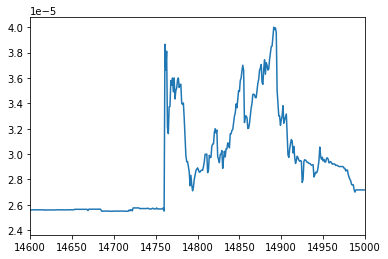

In [56]:
kline_df.Close.plot()
# plt.xlim((14600,15000))
plt.show()

# Maker & Taker analysis

In [17]:
import seaborn as sns

In [18]:
takers_df

,id,price,qty,quoteQty,time,isBuyer
0,1305826000,44807.15,0.00299,133.973378,1648395881176,False
1,1305826001,44807.16,0.0068,304.688688,1648395881393,True
2,1305826002,44807.15,0.00445,199.391818,1648395881532,False
3,1305826003,44807.15,0.01227,549.783731,1648395881699,False
4,1305826004,44807.15,0.01,448.0715,1648395881709,False
...,...,...,...,...,...,...
9456369,1320825994,42483.27,0.00257,109.182004,1649479680037,False
9456370,1320825995,42483.27,0.00049,20.816802,1649479680039,False
9456371,1320825997,42483.27,0.00164,69.672563,1649479680040,False
9456372,1320825998,42483.27,0.00082,34.836281,1649479680041,False


In [19]:
makers_df

,id,price,qty,quoteQty,time,isBuyer
0,1305826000,44807.15,0.00299,133.973378,1648395881176,True
1,1305826001,44807.16,0.0068,304.688688,1648395881393,False
2,1305826009,44807.15,0.07006,3139.188929,1648395882019,True
3,1305826011,44807.16,0.1342,6013.120872,1648395883314,False
4,1305826012,44807.16,0.05062,2268.138439,1648395883314,False
...,...,...,...,...,...,...
9789036,1320825992,42483.28,0.00203,86.241058,1649479680035,False
9789037,1320825993,42483.27,0.00138,58.626913,1649479680037,True
9789038,1320825996,42483.27,0.00242,102.809513,1649479680040,True
9789039,1320825998,42483.27,0.00172,73.071224,1649479680041,True


In [ ]:
sns.histplot(takers_df[:1000000].qty)
plt.ylim((0,10))
plt.show()

In [ ]:
makers_df.qty.describe()
